In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pathlib
import numpy as np

In [137]:
model_binder = [
    ('1', '0'),
    ('2', '0'),
    ('2', '1'),
    ('3', '2'),
]

idx = 3

name = 'dimer_trop2_human_binder_' + model_binder[idx][0] + '_model_' + model_binder[idx][1]
print('Analyzing ' + name)
path = './out_' + name

pt_files = list(pathlib.Path(path + '/stats').glob('*.pt'))
data_list = [torch.load(f) for f in pt_files]
print("\nLoaded statistics from", len(data_list),"structures:")
for key in data_list[0]:
    try:
        print('\t', key, data_list[0][key].size())
    except:
        print('\t', key, data_list[0][key])
print('Totalling', len(data_list)*data_list[0]['generated_sequences'].size()[0], 'sequences')

# because Torben is doing so, we will now average all probs
# This is to mitigate sampling effects, because the probs at each position change depending on which position was already fixed before
# Additionally we combine all relaxed structures into the average to incorporate some flexibility
all_probs = [data['sampling_probs'] for data in data_list]
all_probs = torch.cat(all_probs, dim=0)
print('\nCombined all probabilities into a tensor of size', all_probs.size())

mean_probs = torch.mean(all_probs, dim=0)
print('And averaged into', mean_probs.size())

wt_aa = data_list[0]['native_sequence']
max_probs, max_prob_aa = torch.max(mean_probs, dim=1)
# keep only postions where mpnn wants to change the amino acid
identity_mask = max_prob_aa != wt_aa
# keep only positions where mpnn has at least some uncertainty about the selection
prob_mask = max_probs < 0.95
# combine with or to keep positions where either something else gets selected or mpnn hat some uncertainty what to keep
mask = (identity_mask | prob_mask) & data_list[0]['chain_mask'].bool()

mean_probs = mean_probs[mask]
print('Masked to:', mean_probs.size())

# the wildtype sequence is always the same as the only input difference is the relax result
seq_file = path + '/seqs/' + name + '_0001.fa'
with open(seq_file, 'r') as f:
    lines = f.readlines()
    wt_seq = list(''.join(lines[1].strip().split(':')))
    wt_seq = np.array(wt_seq)
print('\nNative sequence length:', wt_seq.shape)
wt_des_seq = wt_seq[mask]
print('Designed AAs:', wt_des_seq.shape)
wt_des_ind = np.where(mask)[0]
print('Designed AA indices:', wt_des_ind.shape)

Analyzing dimer_trop2_human_binder_3_model_2

Loaded statistics from 7 structures:
	 generated_sequences torch.Size([100, 648])
	 sampling_probs torch.Size([100, 648, 20])
	 log_probs torch.Size([100, 648, 21])
	 decoding_order torch.Size([100, 648])
	 native_sequence torch.Size([648])
	 mask torch.Size([648])
	 chain_mask torch.Size([648])
	 seed 420
	 temperature 0.1
Totalling 700 sequences

Combined all probabilities into a tensor of size torch.Size([700, 648, 20])
And averaged into torch.Size([648, 20])
Masked to: torch.Size([30, 20])

Native sequence length: (648,)
Designed AAs: (30,)
Designed AA indices: (30,)


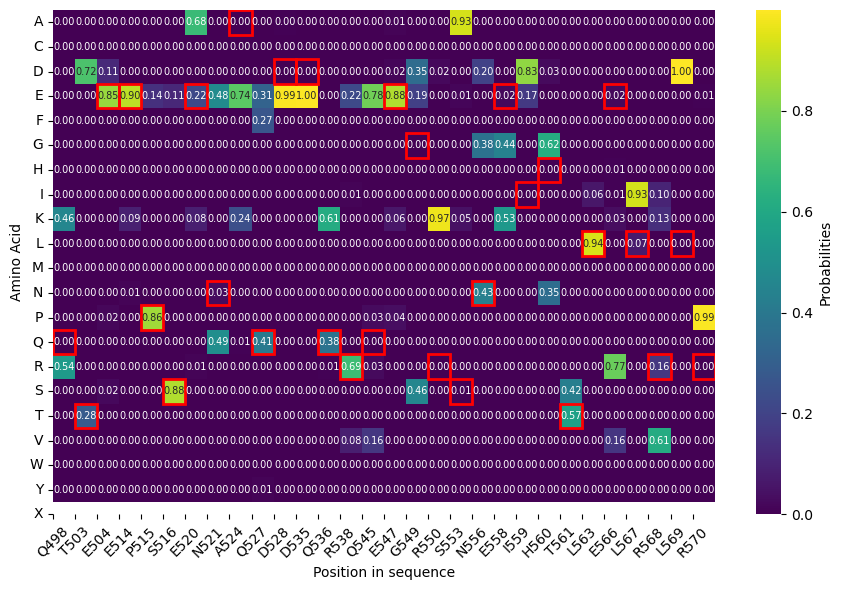

In [138]:
AA = 'ACDEFGHIKLMNPQRSTVWYX'
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

#val = [comb_probs, comb_log_probs]
sns.heatmap(
    mean_probs.T, 
    ax=ax, 
    cbar_kws={'label': 'Probabilities'}, 
    cmap='viridis',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7},
)
ax.set_xlabel('Position in sequence')
ax.set_xticks(list(range(len(wt_des_seq))), [f'{aa}{pos}' for pos, aa in zip(wt_des_ind+1, wt_des_seq)],
    rotation=45,)

ax.set_ylabel('Amino Acid')
ax.set_yticks(np.arange(len(AA))+0.5);
ax.set_yticklabels(list(AA), rotation=0);

for j, aa in enumerate(wt_des_seq):
    aa_idx = AA.index(aa)
    ax.add_patch(
        plt.Rectangle(
            (j, aa_idx), 
            width=1, 
            height=1,
            fill=False, 
            edgecolor='red', 
            lw=2
        )
    )

plt.tight_layout()
fig.savefig(f'figures/{name}_probs_heatmap.png', dpi=300)